# CICIDS2017

## EDA and Preprocessing

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

2024-03-29 18:40:32.599532: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 18:40:32.599576: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 18:40:32.599605: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 18:40:32.606696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
nRowsRead = None 

df1=pd.read_csv(r"../dataset/Tuesday-WorkingHours.pcap_ISCX.csv")
df2=pd.read_csv(r"../dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df3=pd.read_csv(r"../dataset/Monday-WorkingHours.pcap_ISCX.csv")
df4=pd.read_csv(r"../dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df5=pd.read_csv(r"../dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df6=pd.read_csv(r"../dataset/Wednesday-workingHours.pcap_ISCX.csv")
df7=pd.read_csv(r"../dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df8=pd.read_csv(r"../dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv")

In [3]:
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8

nRow, nCol = df.shape

In [4]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,179,0,89.5,103.345698,1246875.000,17187.500000,64.000000,135.557286,445,1,640,106.666667,194.325157,497,1,538,179.333333,303.686242,530,4,0,0,0,0,164,104,10937.500000,6250.000000,0,220,66.500000,99.001837,9801.363636,0,0,0,1,0,0,0,0,0,72.545455,62.857143,89.5,164,0,0,0,0,0,0,7,440,4,358,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,1472,0,736.0,849.859596,3937777.778,14444.444440,75.000000,192.795228,684,1,900,112.500000,252.411229,734,1,766,255.333333,435.323252,758,3,0,0,0,0,204,104,10000.000000,4444.444444,0,1472,253.142857,527.434262,278186.901100,0,0,0,1,0,0,0,0,0,272.615385,66.666667,736.0,204,0,0,0,0,0,0,9,600,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,0,707.5,816.950631,4652282.158,9128.630705,120.500000,236.433336,777,1,1205,200.833333,397.058392,1008,1,927,309.000000,491.647231,876,1,0,0,0,0,164,104,5809.128631,3319.502075,0,1415,467.166667,690.098917,476236.515200,0,0,0,1,0,0,0,0,0,509.636364,396.571429,707.5,164,0,0,0,0,0,0,7,2776,4,2830,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,185,0,92.5,106.809800,1608610.568,21526.418790,51.100000,90.767652,299,1,511,85.166667,131.900594,349,1,462,154.000000,224.719826,412,1,0,0,0,0,164,104,13698.630140,7827.788650,0,226,68.500000,101.933579,10390.454550,0,0,0,1,0,0,0,0,0,74.727273,64.571429,92.5,164,0,0,0,0,0,0,7,452,4,370,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,1472,0,736.0,849.859596,4600258.732,16817.593790,64.416667,148.698266,531,1,773,96.625000,196.665733,580,1,675,225.000000,348.901132,627,1,0,0,0,0,204,104,11642.949550,5174.644243,0,1472,254.000000,527.520762,278278.153800,0,0,0,1,0,0,0,0,0,273.538461,68.000000,736.0,204,0,0,0,0,0,0,9,612,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
from itertools import combinations
def data_cleaning(df):
    df.columns=df.columns.str.strip()
    print("Dataset Shape: ",df.shape)
    
    num=df._get_numeric_data()
    num[num<0]=0
    
    zero_variance_cols=[]
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(columns=zero_variance_cols, axis=1, inplace=True)
    print("Zero Variance Columns: ", zero_variance_cols, "are dropped.")
    print("Shape after removing the zero varaince columns: ",df.shape)
    
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    print(df.isna().any(axis=1).sum(),"rows dropped")
    df.dropna(inplace=True)
    print("Shape after Removing NaN: ",df.shape)
    
    df.drop_duplicates(inplace=True)
    print("Shape after dropping duplicates: ",df.shape)
    
    column_pairs = [(i,j) for i,j in combinations(df,2) if df[i].equals(df[j])]
    ide_cols=[]
    for col_pair in column_pairs:
        ide_cols.append(col_pair[1])
    df.drop(columns=ide_cols,axis=1,inplace=True)
    print("Columns which have identical values: ",column_pairs," dropped!")
    print("Shape after removing identical value columns: ",df.shape)
    return df
df=data_cleaning(df)

Dataset Shape:  (2830743, 79)
Zero Variance Columns:  ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'] are dropped.
Shape after removing the zero varaince columns:  (2830743, 71)
2867 rows dropped
Shape after Removing NaN:  (2827876, 71)
Shape after dropping duplicates:  (2520798, 71)
Columns which have identical values:  [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Header Length', 'Fwd Header Length.1')]  dropped!
Shape after removing identical value columns:  (2520798, 66)


In [6]:
df['Label'].value_counts()

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [7]:
print(df.columns)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2520798 entries, 0 to 191032
Data columns (total 66 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow I

In [9]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['Label'] = le.fit_transform(df['Label'])

X = df_encoded.drop('Label', axis=1)
y = df_encoded['Label']

In [10]:
X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
print(y_train.value_counts())





Label
BENIGN                        1676045
DoS Hulk                       138277
DDoS                           102411
PortScan                        72555
DoS GoldenEye                    8229
FTP-Patator                      4745
DoS slowloris                    4308
DoS Slowhttptest                 4182
SSH-Patator                      2575
Bot                              1558
Web Attack � Brute Force         1176
Web Attack � XSS                  522
Infiltration                       29
Web Attack � Sql Injection         17
Heartbleed                          9
Name: count, dtype: int64


In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Define the sampling strategies
sampling_strategy_over = {
    "DoS Hulk": 200000, 
    "DDoS": 150000, 
    "PortScan": 100000, 
    "DoS GoldenEye": 10000, 
    "FTP-Patator": 10000, 
    "DoS slowloris": 10000, 
    "DoS Slowhttptest": 10000, 
    "SSH-Patator": 10000, 
    "Bot": 10000, 
    "Web Attack � Brute Force": 10000, 
    "Web Attack � XSS": 10000, 
    "Infiltration": 10000, 
    "Web Attack � Sql Injection": 10000, 
    "Heartbleed": 10000
}

sampling_strategy_under = {
    "BENIGN": 500000
}


over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

In [13]:
over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)



X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res= under.fit_resample(X_train_res, y_train_res)

print(y_train_res.value_counts())


Label
BENIGN                        500000
DoS Hulk                      200000
DDoS                          150000
PortScan                      100000
Bot                            10000
DoS GoldenEye                  10000
DoS Slowhttptest               10000
DoS slowloris                  10000
FTP-Patator                    10000
Heartbleed                     10000
Infiltration                   10000
SSH-Patator                    10000
Web Attack � Brute Force       10000
Web Attack � Sql Injection     10000
Web Attack � XSS               10000
Name: count, dtype: int64


In [14]:
# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for Conv1D
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# One-hot encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_res)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Calculate class weights (for scikit-learn version >= 0.22.0)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weight_dict = dict(zip(np.unique(y_train_res), class_weights))

In [15]:
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.optimizers import Adam



# Define the LSTM model
model_lstm = Sequential()
# model_lstm.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.001)))
# model_lstm.add(BatchNormalization())
# model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(50, input_shape=(X_train_scaled.shape[1], 1), return_sequences= True ))  
model_lstm.add(Dropout(0.01))
model_lstm.add(LSTM(50,return_sequences=True)) 
model_lstm.add(Dropout(0.01))

model_lstm.add(LSTM(50, return_sequences=False)) 
model_lstm.add(Dropout(0.01))
model_lstm.add(Dense(y_train_one_hot.shape[1]))
model_lstm.add(Activation('softmax'))





optimizer = Adam(learning_rate=1e-4)
model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train_scaled, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test_one_hot))

2024-03-29 16:24:55.803104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 67152 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-03-29 16:24:55.804564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79065 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-03-29 16:24:56.809742: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/10


2024-03-29 16:25:00.069649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-29 16:25:00.680693: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3e163797c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-29 16:25:00.680731: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-29 16:25:00.680740: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-29 16:25:00.688027: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-29 16:25:00.781106: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33125/33125 [==============================] - 497s 15ms/step - loss: 0.6071 - accuracy: 0.8064 - val_loss: 0.3066 - val_accuracy: 0.9039
Epoch 2/10
33125/33125 [==============================] - 492s 15ms/step - loss: 0.3342 - accuracy: 0.8840 - val_loss: 0.1912 - val_accuracy: 0.9312
Epoch 3/10
33125/33125 [==============================] - 498s 15ms/step - loss: 0.2664 - accuracy: 0.9050 - val_loss: 0.1717 - val_accuracy: 0.9275
Epoch 4/10
33125/33125 [==============================] - 484s 15ms/step - loss: 0.2262 - accuracy: 0.9183 - val_loss: 0.1471 - val_accuracy: 0.9481
Epoch 5/10
33125/33125 [==============================] - 574s 17ms/step - loss: 0.2100 - accuracy: 0.9260 - val_loss: 0.1451 - val_accuracy: 0.9472
Epoch 6/10
33125/33125 [==============================] - 498s 15ms/step - loss: 0.1989 - accuracy: 0.9303 - val_loss: 0.1414 - val_accuracy: 0.9406
Epoch 7/10
33125/33125 [==============================] - 508s 15ms/step - loss: 0.1627 - accuracy: 0.9415 - val_loss

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test_scaled, y_test_one_hot)

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

15755/15755 [==============================] - 89s 6ms/step - loss: 0.0932 - accuracy: 0.9634
Test Accuracy: 96.34%
Test Loss: 9.32%


In [17]:
y_pred = model_lstm.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test_one_hot, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

15755/15755 [==============================] - 81s 5ms/step
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.96      0.98    419012
                       Bot       0.27      0.73      0.40       390
                      DDoS       0.98      0.98      0.98     25603
             DoS GoldenEye       0.79      0.94      0.86      2057
                  DoS Hulk       0.95      0.99      0.97     34569
          DoS Slowhttptest       0.81      0.95      0.87      1046
             DoS slowloris       0.71      0.93      0.81      1077
               FTP-Patator       0.88      0.99      0.93      1186
                Heartbleed       0.12      0.50      0.20         2
              Infiltration       0.02      1.00      0.04         7
                  PortScan       0.68      0.99      0.80     18139
               SSH-Patator       0.92      0.90      0.91       644
  Web Attack � Brute Force       0.16      0.69      0.

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


Precision: 0.9782012040431656
Recall: 0.9634401777213583
F1 Score: 0.9691615795619429
Accuracy: 0.9634401777213583


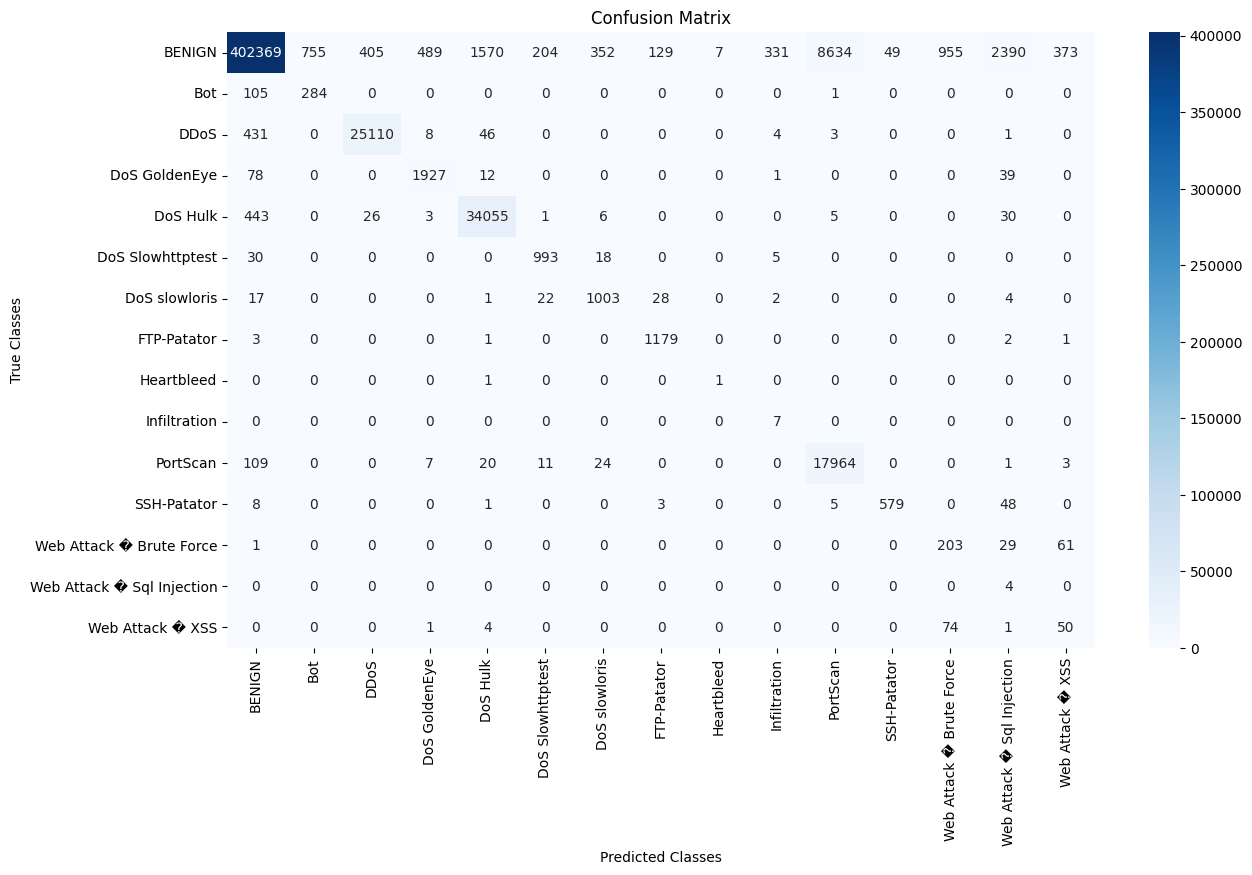

In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

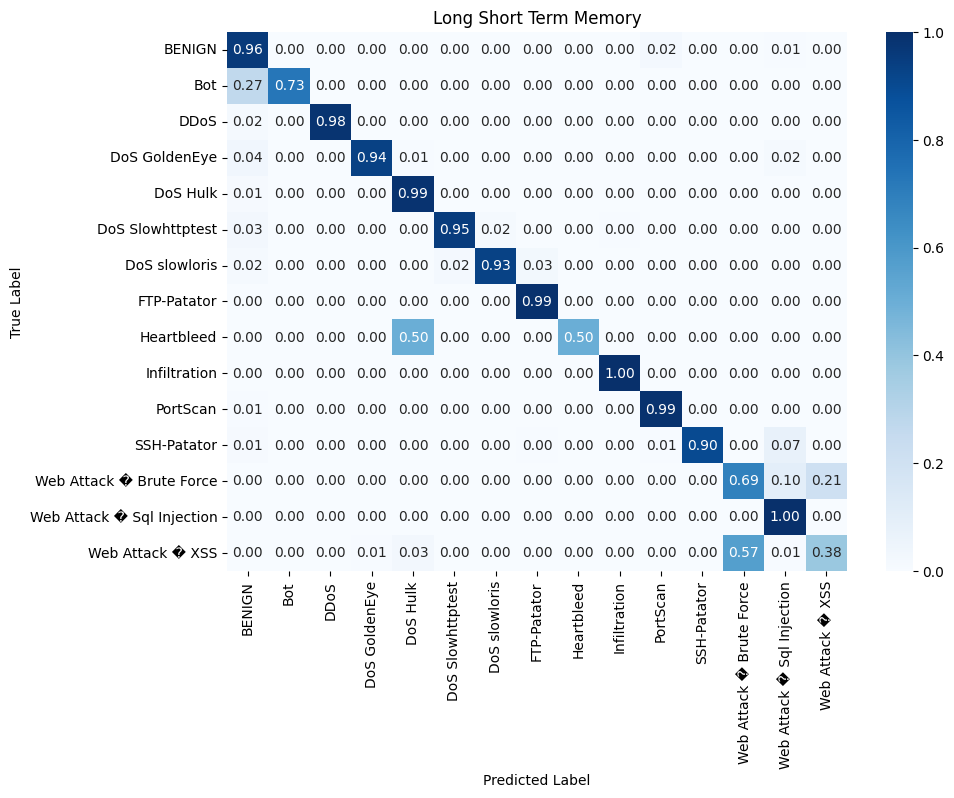

In [20]:
# Normalize the confusion matrix by rows
row_sums = conf_matrix.sum(axis=1)
conf_matrix_normalized = conf_matrix / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Long Short Term Memory")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

# Compute micro average precision, recall, f1-score
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


Micro Average Precision: 0.5608
Micro Average Recall: 0.8620
Micro Average F1-Score: 0.6122
Precision: 0.9782012040431656
Recall: 0.9634401777213583
F1 Score: 0.9691615795619429
Accuracy: 0.9634401777213583


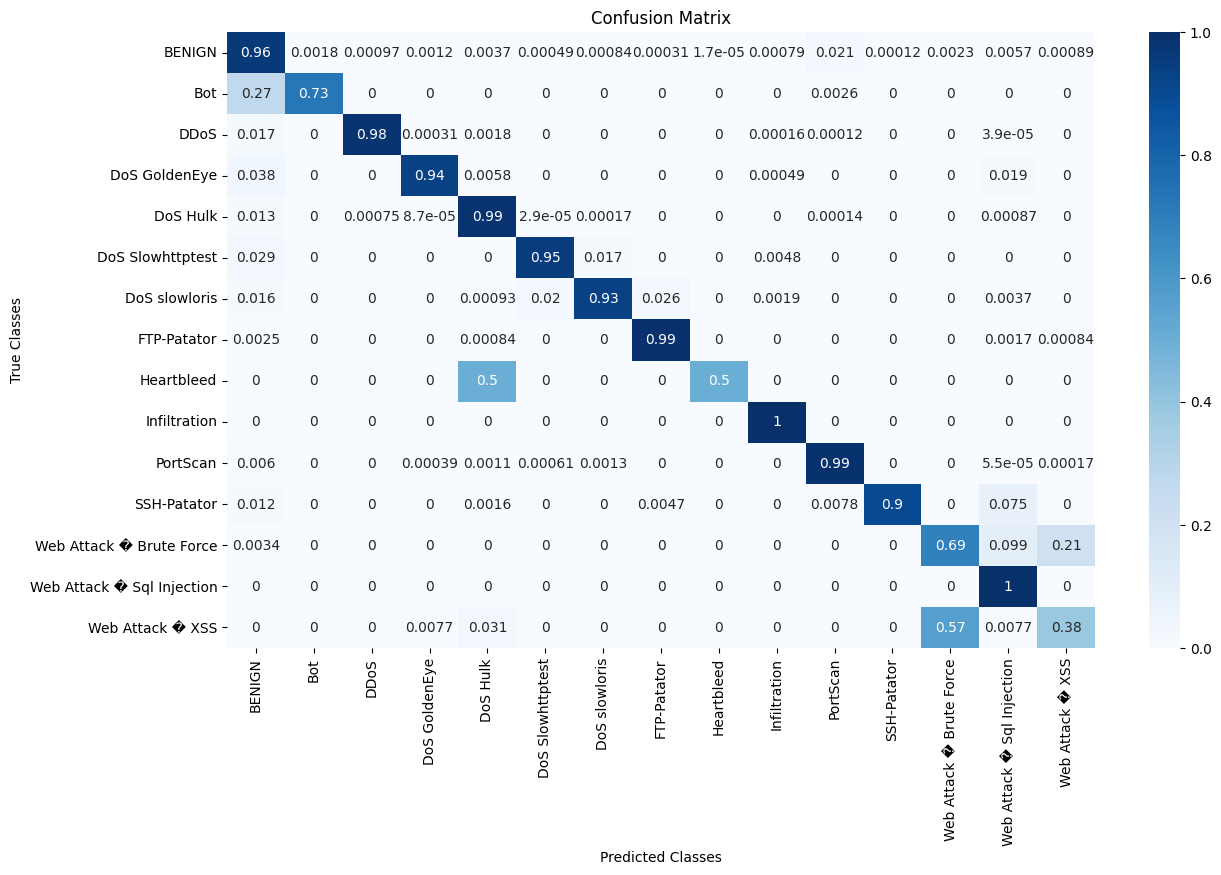

In [25]:
# Confusion matrix
conf_matrix_2 = confusion_matrix(y_true, y_pred_classes, normalize="true")

# Plot the confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_2, annot=True, cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

## LSTM with fine tuning

In [16]:
!nvidia-smi

Fri Mar 29 18:34:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:01:00.0 Off |                    0 |
| N/A   43C    P0             65W /  300W |   81022MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [16]:
!export CUDA_VISIBLE_DEVICES=1


In [17]:
import tensorflow as tf

gpu_device = '/device:GPU:1'

In [18]:

with tf.device(gpu_device):

    # Early Stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # fine-tuned model
    model_lstm_fine_tuned = Sequential()
    model_lstm_fine_tuned.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
    model_lstm_fine_tuned.add(Dropout(0.2))
    model_lstm_fine_tuned.add(LSTM(32, activation='tanh'))
    model_lstm_fine_tuned.add(Dropout(0.2))
    model_lstm_fine_tuned.add(Dense(50, activation='relu'))
    model_lstm_fine_tuned.add(Dense(y_train_one_hot.shape[1], activation='softmax'))

    # Compile the model with adjusted optimizer and learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model_lstm_fine_tuned.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model with callbacks
    history_fine_tuned = model_lstm_fine_tuned.fit(
        X_train_scaled, y_train_one_hot, 
        epochs=10,
        batch_size=32,  
        validation_data=(X_test_scaled, y_test_one_hot), 
        callbacks=[early_stopping, reduce_lr],
    )

Epoch 1/10


2024-03-29 18:45:20.426011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-29 18:45:21.040670: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1891feb460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-29 18:45:21.040697: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-29 18:45:21.040703: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-29 18:45:21.045646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-29 18:45:21.116995: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33125/33125 [==============================] - 374s 11ms/step - loss: 1.1948 - accuracy: 0.6398 - val_loss: 0.3825 - val_accuracy: 0.8881 - lr: 1.0000e-04
Epoch 2/10
33125/33125 [==============================] - 372s 11ms/step - loss: 0.6202 - accuracy: 0.7942 - val_loss: 0.2849 - val_accuracy: 0.8976 - lr: 1.0000e-04
Epoch 3/10
33125/33125 [==============================] - 371s 11ms/step - loss: 0.4720 - accuracy: 0.8369 - val_loss: 0.2474 - val_accuracy: 0.9220 - lr: 1.0000e-04
Epoch 4/10
33125/33125 [==============================] - 373s 11ms/step - loss: 0.4056 - accuracy: 0.8574 - val_loss: 0.2142 - val_accuracy: 0.9271 - lr: 1.0000e-04
Epoch 5/10
33125/33125 [==============================] - 372s 11ms/step - loss: 0.3593 - accuracy: 0.8735 - val_loss: 0.2217 - val_accuracy: 0.9187 - lr: 1.0000e-04
Epoch 6/10
33125/33125 [==============================] - 372s 11ms/step - loss: 0.3268 - accuracy: 0.8860 - val_loss: 0.2152 - val_accuracy: 0.9097 - lr: 1.0000e-04
Epoch 7/10
3312

In [20]:
with tf.device(gpu_device):

    # Evaluate the model on the test set
    test_loss, test_accuracy = model_lstm_fine_tuned.evaluate(X_test_scaled, y_test_one_hot)

    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
    print("Test Loss: {:.2f}%".format(test_loss * 100))

15755/15755 [==============================] - 71s 5ms/step - loss: 0.1224 - accuracy: 0.9510
Test Accuracy: 95.10%
Test Loss: 12.24%


In [22]:
with tf.device(gpu_device):

    y_pred = model_lstm_fine_tuned.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true = np.argmax(y_test_one_hot, axis=1)

    # Classification report
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

15755/15755 [==============================] - 62s 4ms/step
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.95      0.97    419012
                       Bot       0.54      0.59      0.56       390
                      DDoS       0.92      0.92      0.92     25603
             DoS GoldenEye       0.69      0.89      0.78      2057
                  DoS Hulk       0.86      0.98      0.92     34569
          DoS Slowhttptest       0.73      0.90      0.81      1046
             DoS slowloris       0.84      0.83      0.83      1077
               FTP-Patator       0.86      0.99      0.92      1186
                Heartbleed       0.17      0.50      0.25         2
              Infiltration       0.01      1.00      0.01         7
                  PortScan       0.65      0.97      0.78     18139
               SSH-Patator       0.77      0.90      0.83       644
  Web Attack � Brute Force       0.15      0.52      0.

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


Precision: 0.9674203640057382
Recall: 0.9509976991431291
F1 Score: 0.9571755646980156
Accuracy: 0.9509976991431291


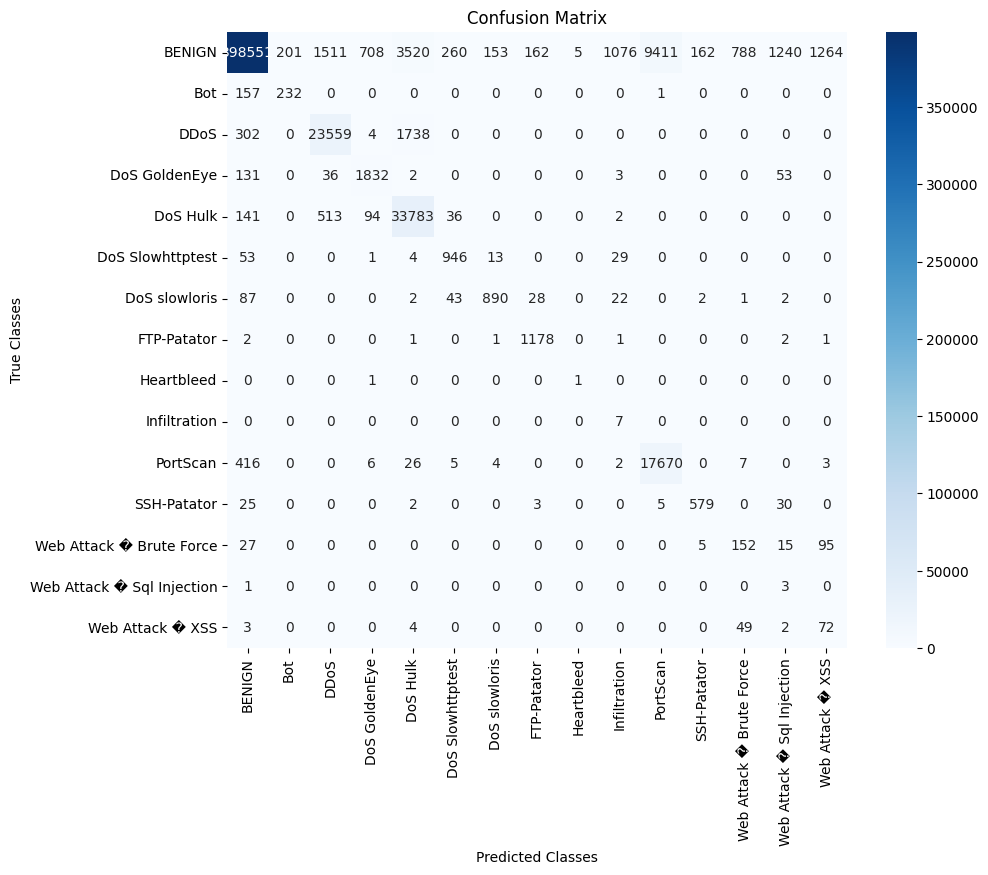

In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

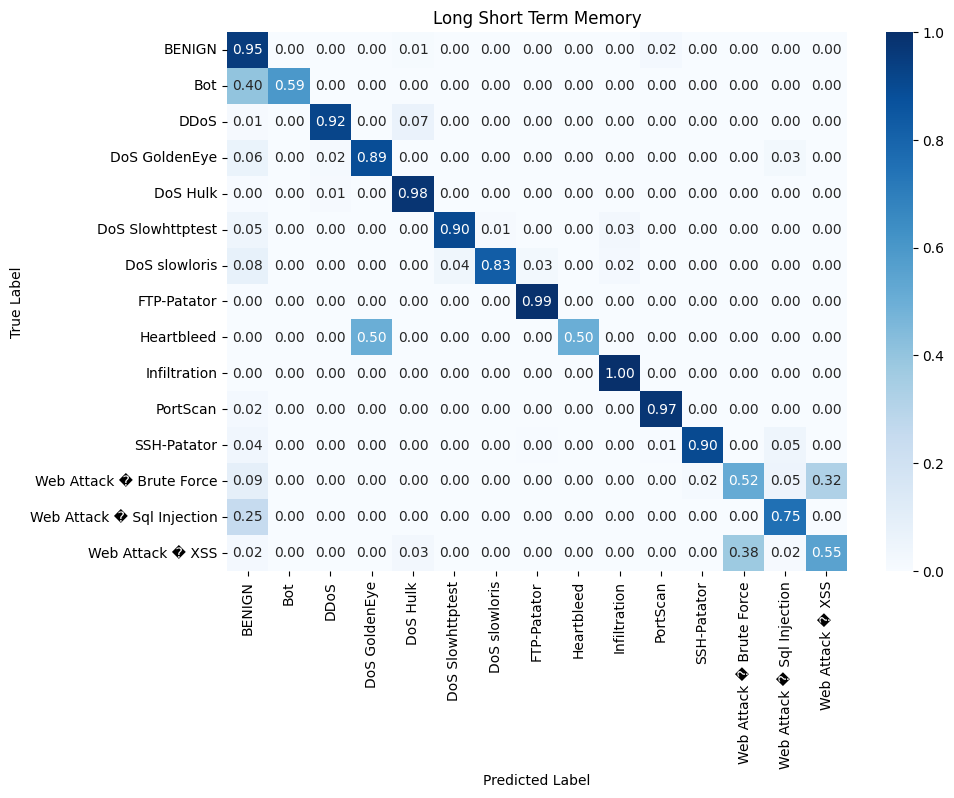

In [25]:
# Normalize the confusion matrix by rows
row_sums = conf_matrix.sum(axis=1)
conf_matrix_normalized = conf_matrix / row_sums[:, np.newaxis]

# Plot the normalized confusion matrixa
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Long Short Term Memory")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


Micro Average Precision: 0.5496
Micro Average Recall: 0.8168
Micro Average F1-Score: 0.5950
Precision: 0.9674203640057382
Recall: 0.9509976991431291
F1 Score: 0.9571755646980156
Accuracy: 0.9509976991431291
